In [37]:
## !pip install lightgbm
## !pip install joblib

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
import lightgbm as lgb
import joblib

In [2]:
label_encoder = LabelEncoder()

# **Data Exploration**

## Loading and merging datasets based on the `id_job`

In [3]:
pd.set_option('display.max_columns', None)

dcgm_data = pd.read_csv('dcgm.csv')
scheduler_data = pd.read_csv('scheduler_data.csv')

df = pd.merge(dcgm_data, scheduler_data, on='id_job')

In [4]:
df.head(5)

,Node,avgmemoryutilization_pct,avgsmutilization_pct,energyconsumed_joules,gpu_id,maxgpumemoryused_bytes,memoryutilization_pct_avg,memoryutilization_pct_max,memoryutilization_pct_min,pcierxbandwidth_megabytes_avg,pcierxbandwidth_megabytes_max,pcierxbandwidth_megabytes_min,pcietxbandwidth_megabytes_avg,pcietxbandwidth_megabytes_max,pcietxbandwidth_megabytes_min,powerusage_watts_avg,powerusage_watts_max,powerusage_watts_min,smutilization_pct_avg,smutilization_pct_max,smutilization_pct_min,totalexecutiontime_sec,id_job,id_array_job,id_array_task,id_user,kill_requid,nodes_alloc,nodelist,cpus_req,derived_ec,exit_code,gres_req,gres_alloc,gres_used,array_max_tasks,array_task_pending,constraints,flags,mem_req,partition,priority,state,timelimit,time_submit,time_eligible,time_start,time_end,time_suspended,track_steps,tres_alloc,tres_req,job_type
0,r9170217-n750018,0.0,1.0,157521.0,0,2.645557e+09,3.0,24.0,0.0,1646.0,1748.0,1613.0,971.0,1530.0,676.0,44.0546,156.962,25.468,11.0,64.0,0.0,4452.47,4393785332,4393785332,41161693674,8153593386,8153593386,1,['r9170217-n750018'],20,0,0,gpu:volta:1,gpu:1,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10509,4,4294967295,26341707,26341708,26341708,26346159,-1,0,"1=20,2=170000,3=18446744073709551614,4=1,5=20,...","1=20,2=170000,4=1,5=20,1002=1",LLSUB:BATCH
1,r44132-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.000,0.000,0.0,0.0,0.0,0.54,18177101425,18177101425,41161693674,8153593386,51671871839,1,['r44132-n469339'],10,0,0,gpu:volta:1,gpu:1,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10912,3,4294967295,23378738,23378740,23378740,23378740,-1,0,"1=10,2=85000,4=1,5=10,1002=1","1=10,2=85000,4=1,5=10,1002=1",OTHER
2,r5354770-n172107,0.0,3.0,94816.0,0,2.917171e+07,0.0,0.0,0.0,1846.0,1849.0,1838.0,1785.0,1872.0,1346.0,26.3725,27.483,25.979,6.0,43.0,0.0,8398.30,39529488078,41161693674,4595979483,8153593386,51671871839,1,['r5354770-n172107'],1,0,256,gpu:volta:1,gpu:1,NaN,0,0,xeon-g6,2,9223372036854784308,normal,110935,5,4294967295,23094718,23094718,23094718,23103116,-1,0,"1=1,2=8500,4=1,5=1,1002=1","1=1,2=8500,4=1,5=1,1002=1",LLSUB:INTERACTIVE
3,r1900814-n772143,0.0,0.0,69451.0,0,1.527587e+09,0.0,1.0,0.0,539.0,542.0,536.0,314.0,337.0,293.0,37.5481,52.039,26.676,1.0,25.0,0.0,1851.72,19994333952,63800488125,9124162775,8153593386,8153593386,1,['r1900814-n772143'],20,0,0,gpu:volta:1,gpu:1,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10520,4,4294967295,24845442,24845442,24845442,24847292,-1,0,"1=20,2=170000,3=18446744073709551614,4=1,5=20,...","1=20,2=170000,4=1,5=20,1002=1",LLSUB:BATCH
4,r9515777-n469339,0.0,0.0,0.0,1,0.000000e+00,0.0,0.0,0.0,1991.0,1991.0,1991.0,1109.0,1109.0,1109.0,25.0320,25.032,25.032,0.0,0.0,0.0,0.99,397881706,44824198560,10003786564,8153593386,51671871839,1,['r9515777-n469339'],10,0,512,gpu:volta:1,gpu:1,NaN,0,0,xeon-g6,4,9223372036854784308,normal,10912,5,4294967295,23377439,23377440,23377440,23377441,-1,0,"1=10,2=85000,4=1,5=10,1002=1","1=10,2=85000,4=1,5=10,1002=1",OTHER


In [5]:
dcgm_data.shape

(96893, 23)

In [6]:
scheduler_data.shape

(287173, 31)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97024 entries, 0 to 97023
Data columns (total 53 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Node                           97024 non-null  object 
 1   avgmemoryutilization_pct       97024 non-null  float64
 2   avgsmutilization_pct           97024 non-null  float64
 3   energyconsumed_joules          97024 non-null  float64
 4   gpu_id                         97024 non-null  int64  
 5   maxgpumemoryused_bytes         97024 non-null  float64
 6   memoryutilization_pct_avg      97024 non-null  float64
 7   memoryutilization_pct_max      97024 non-null  float64
 8   memoryutilization_pct_min      97024 non-null  float64
 9   pcierxbandwidth_megabytes_avg  97024 non-null  float64
 10  pcierxbandwidth_megabytes_max  97024 non-null  float64
 11  pcierxbandwidth_megabytes_min  97024 non-null  float64
 12  pcietxbandwidth_megabytes_avg  97024 non-null 

In [8]:
df.isnull().sum()

Node                                 0
avgmemoryutilization_pct             0
avgsmutilization_pct                 0
energyconsumed_joules                0
gpu_id                               0
maxgpumemoryused_bytes               0
memoryutilization_pct_avg            0
memoryutilization_pct_max            0
memoryutilization_pct_min            0
pcierxbandwidth_megabytes_avg        0
pcierxbandwidth_megabytes_max        0
pcierxbandwidth_megabytes_min        0
pcietxbandwidth_megabytes_avg        0
pcietxbandwidth_megabytes_max        0
pcietxbandwidth_megabytes_min        0
powerusage_watts_avg                 0
powerusage_watts_max                 0
powerusage_watts_min                 0
smutilization_pct_avg                0
smutilization_pct_max                0
smutilization_pct_min                0
totalexecutiontime_sec               0
id_job                               0
id_array_job                         0
id_array_task                        0
id_user                  

In [9]:
df['exit_code'].unique()

array([    0,   256,   512, 35072, 33280, 34304, 32512, 32256, 33792,
           9,  1024, 32768,  2048, 35584, 34560, 37888,   253, 65280,
       65024,  3328, 33536,  1792, 61952])

In [10]:
df['state'].unique()

array([   4,    3,    5,    6, 1024,    7,   11,    1])

In [11]:
df['avgmemoryutilization_pct'].describe()

count    97024.000000
mean         7.427533
std         12.626995
min          0.000000
25%          0.000000
50%          0.000000
75%         15.000000
max         85.000000
Name: avgmemoryutilization_pct, dtype: float64

In [12]:
df['gres_alloc'].unique()

array(['gpu:1', 'gpu:3', 'gpu:2', 'gpu:4', 'gpu:8', 'gpu:16', 'gpu:32',
       'gpu:12', 'gpu:10', 'gpu:6', 'gpu:5', 'gpu:64'], dtype=object)

In [13]:
df['gres_req'].unique()

array(['gpu:volta:1', 'gpu:volta:3', 'gpu:volta:2', 'gpu:1', 'gpu:2',
       'gpu:3', 'gpu:volta:4', 'gpu:volta:8', 'gpu:16', 'gpu:volta:16',
       'gpu:32', 'gpu:4', 'gpu:12', 'gpu:8', 'gpu:volta:10',
       'gpu:volta:6', 'gpu:volta:32', 'gpu:volta:5', 'gpu:volta:64',
       'gpu:volta:12', 'gpu:64'], dtype=object)

In [14]:
df['id_user'].unique().size

195

## Add a new column `job_status` to classify job entries based on their status: `SUCCESS` or `FAIL`

In [15]:
df['job_status'] = ''
df['job_status'] = df.apply(lambda row: 'SUCCESS' if row['exit_code'] == 0 else 'FAIL', axis=1)

# **Data Visualization**

## Heatmaps and boxplots

[]

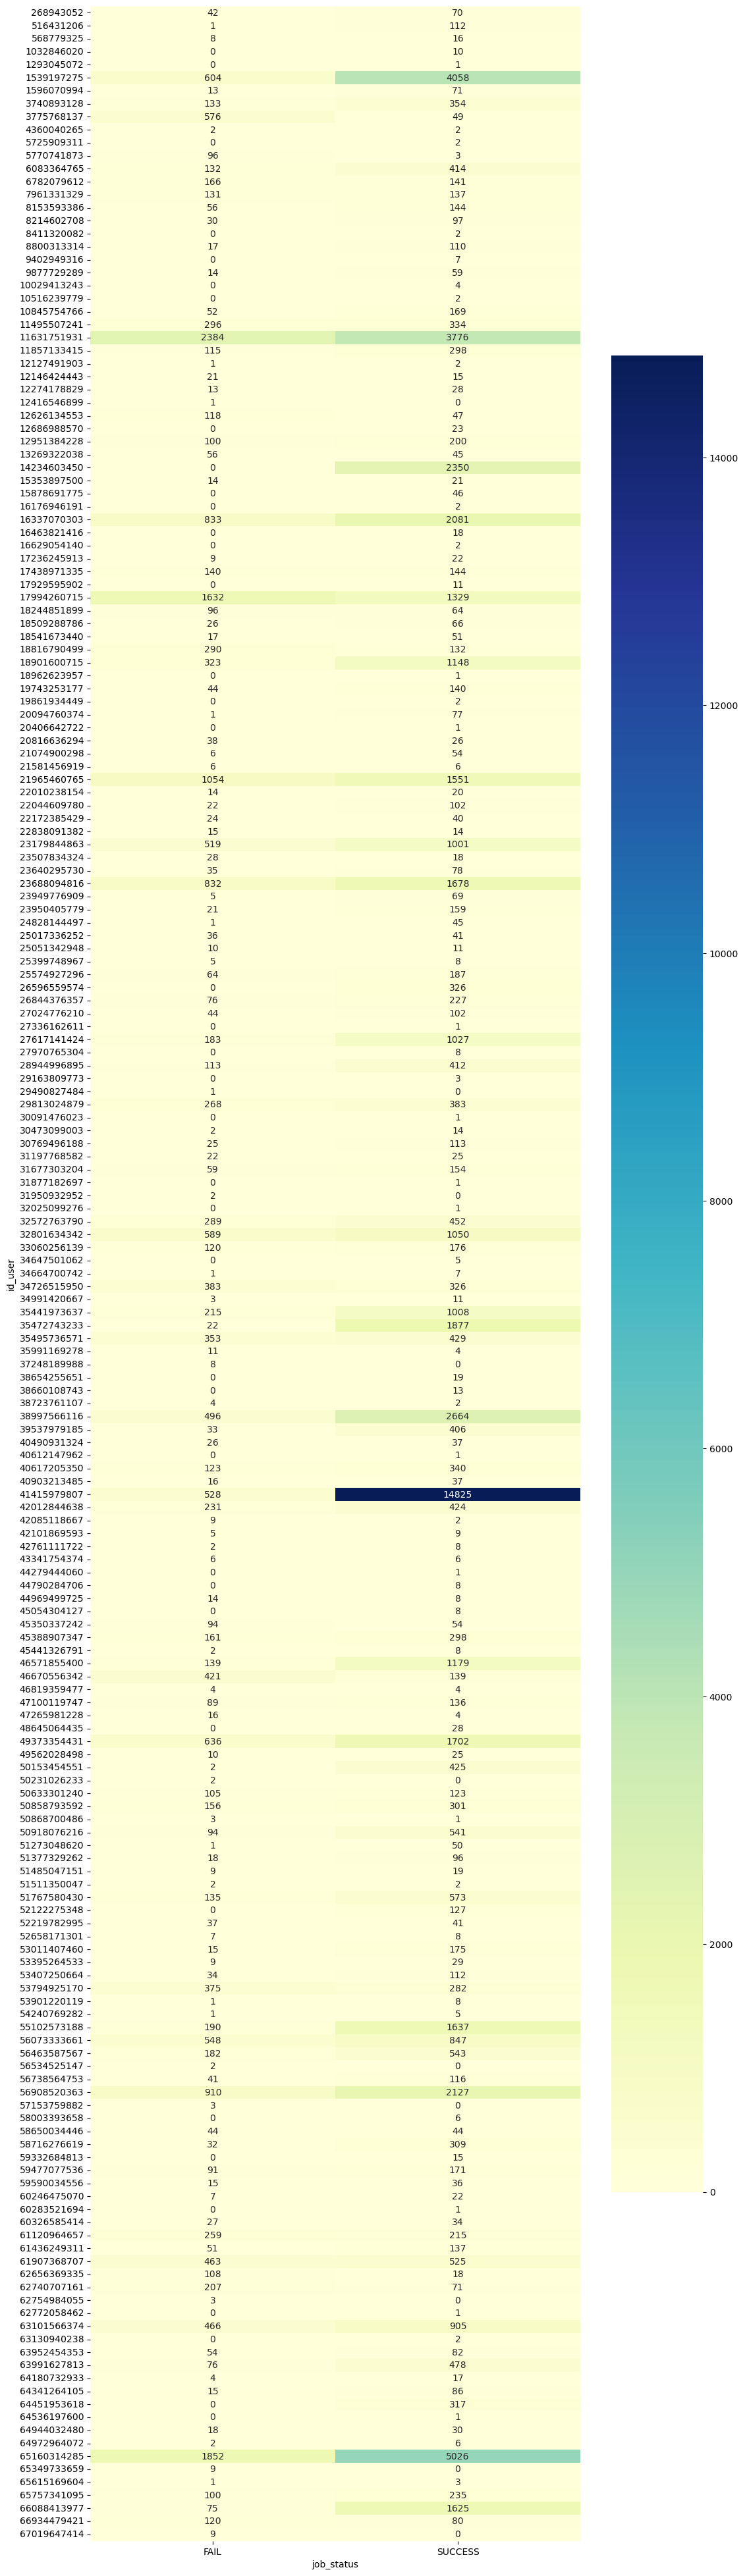

In [16]:
crosstab = pd.crosstab(df['id_user'], df['job_status'])
plt.figure(figsize=(12, 50))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.plot()

[]

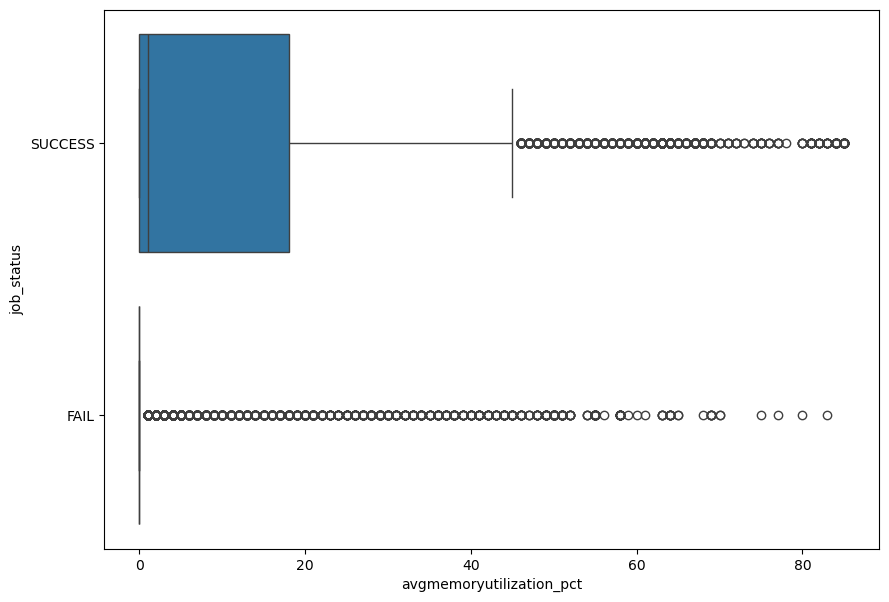

In [17]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='avgmemoryutilization_pct', y='job_status')
plt.plot()

[]

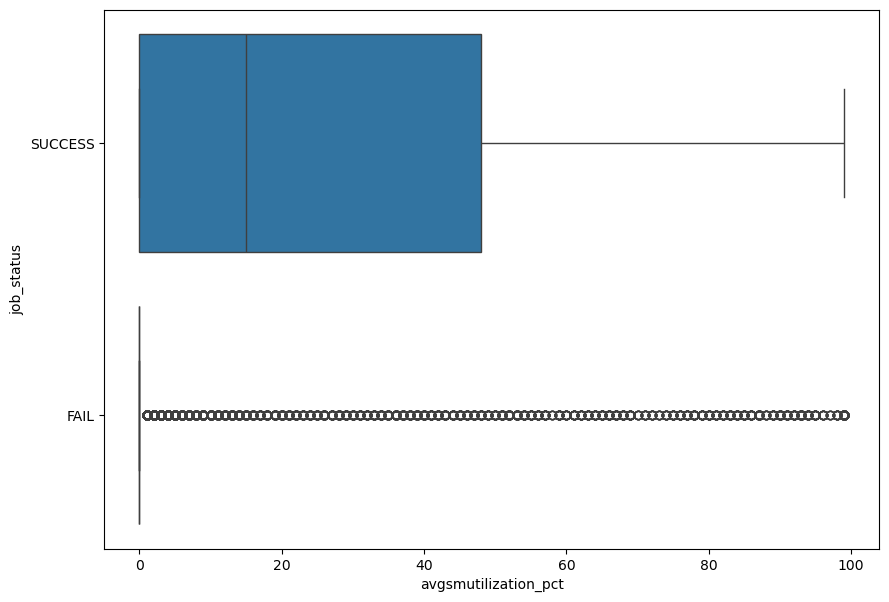

In [18]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='avgsmutilization_pct', y='job_status')
plt.plot()

[]

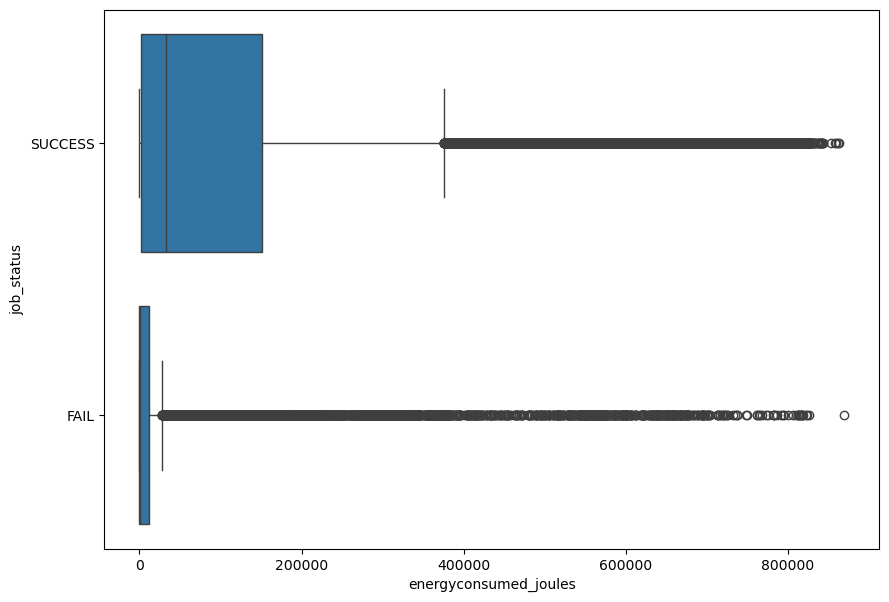

In [19]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='energyconsumed_joules', y='job_status')
plt.plot()

[]

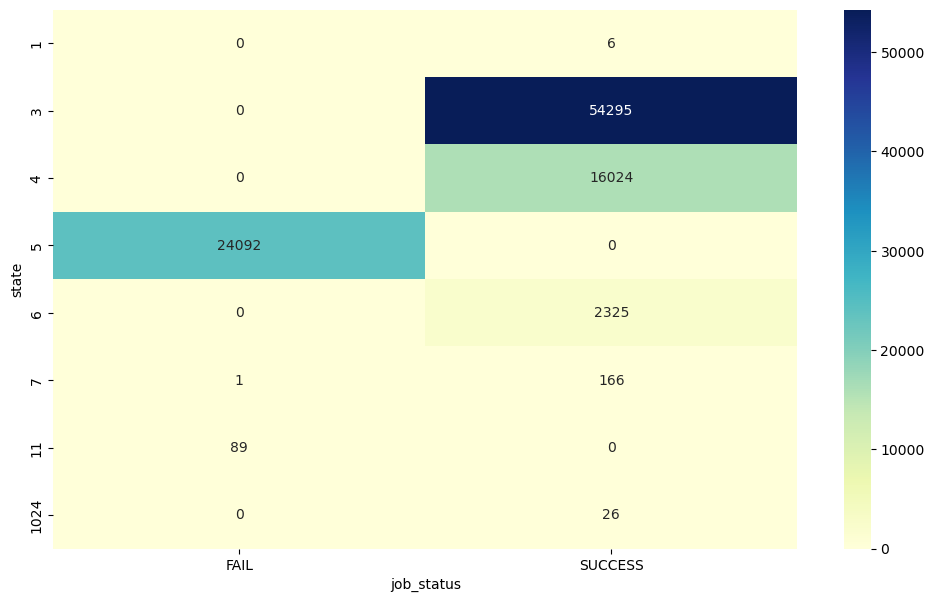

In [20]:
crosstab = pd.crosstab(df['state'], df['job_status'])
plt.figure(figsize=(12, 7))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.plot()

[]

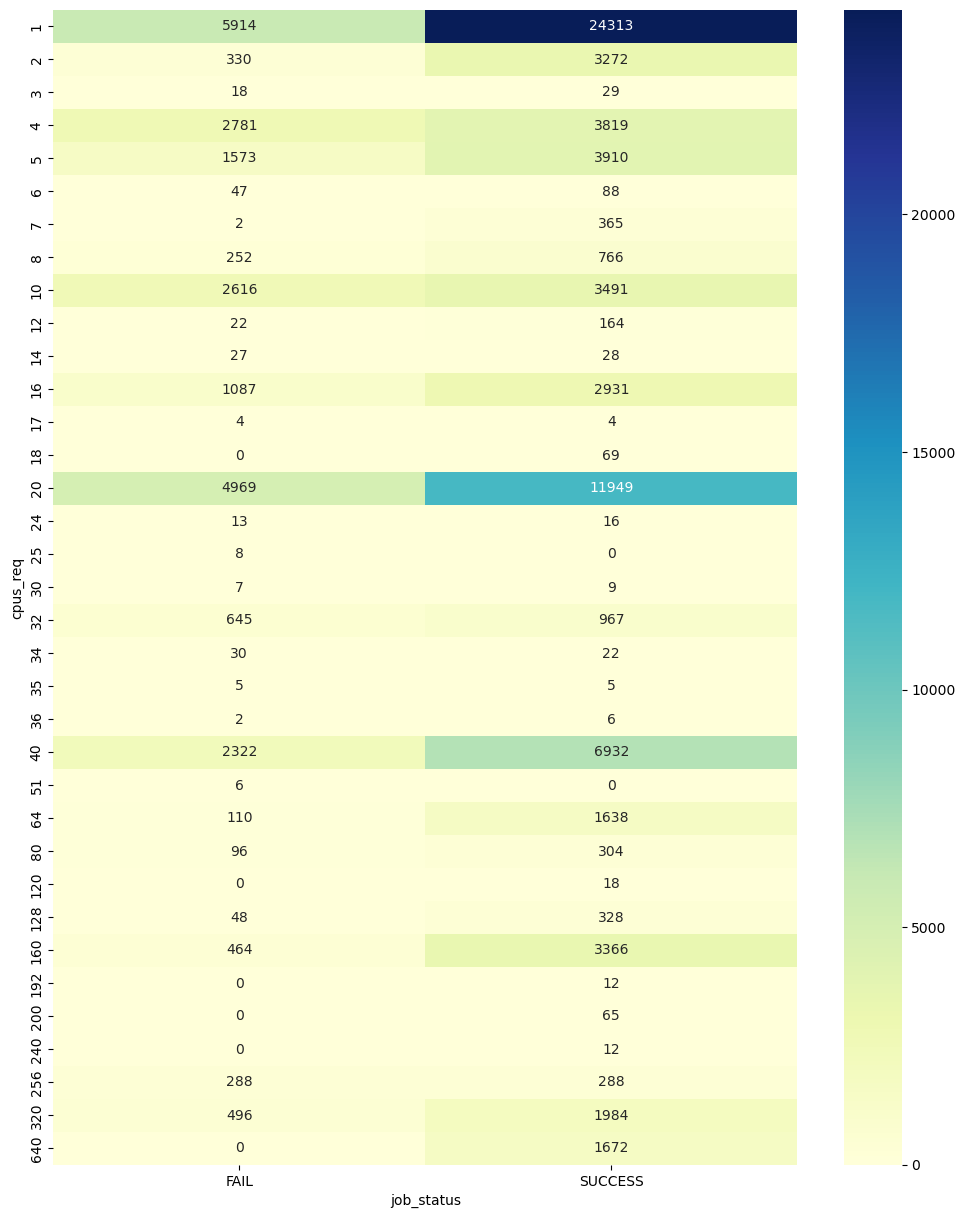

In [21]:
crosstab = pd.crosstab(df['cpus_req'], df['job_status'])
plt.figure(figsize=(12, 15))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.plot()

[]

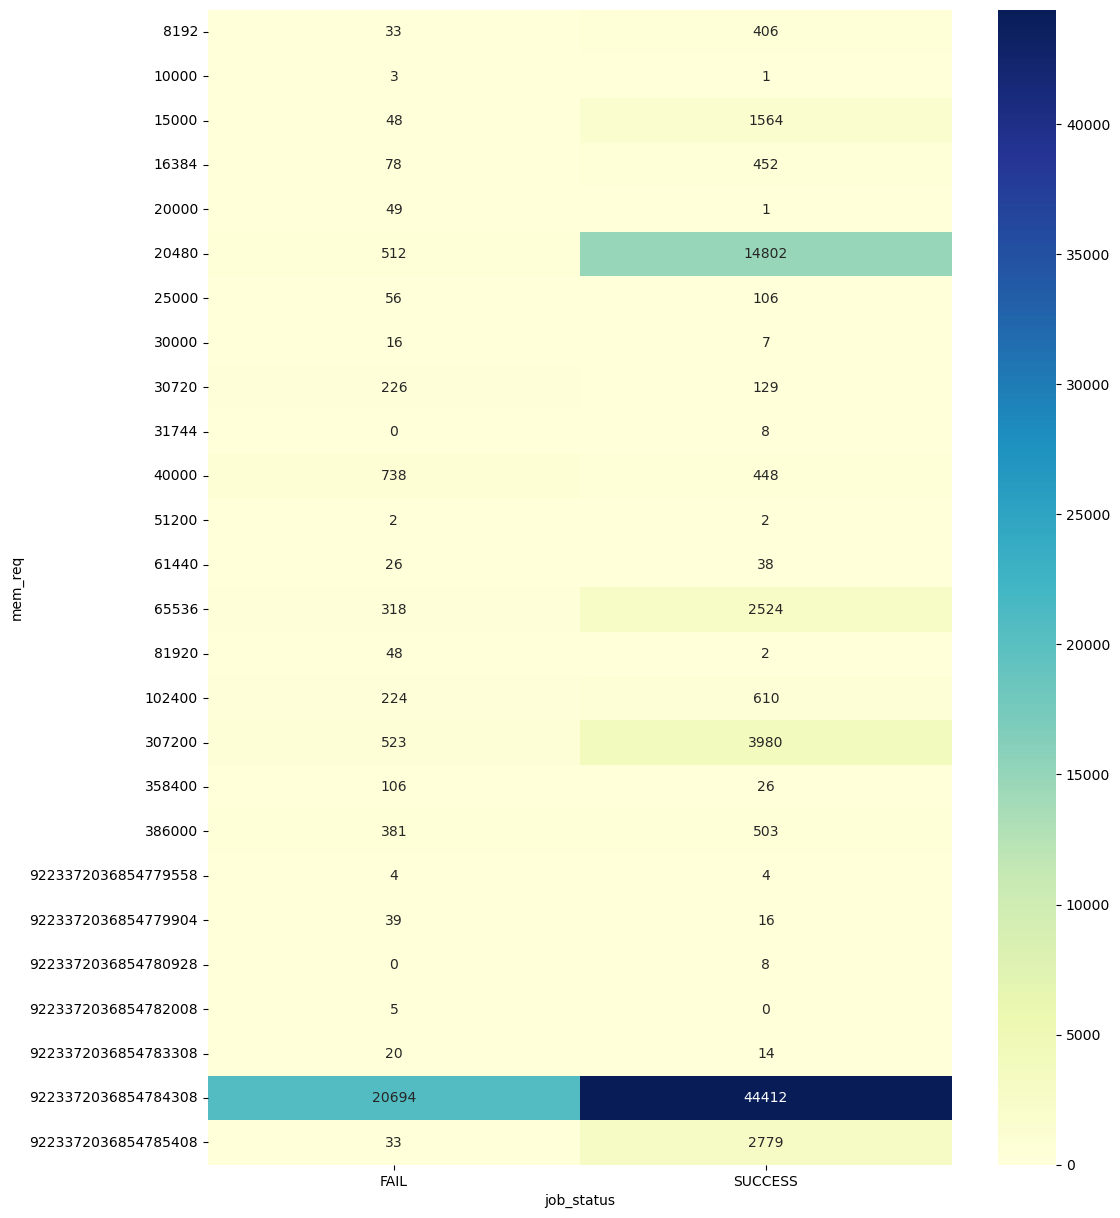

In [22]:
crosstab = pd.crosstab(df['mem_req'], df['job_status'])
plt.figure(figsize=(12, 15))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.plot()

[]

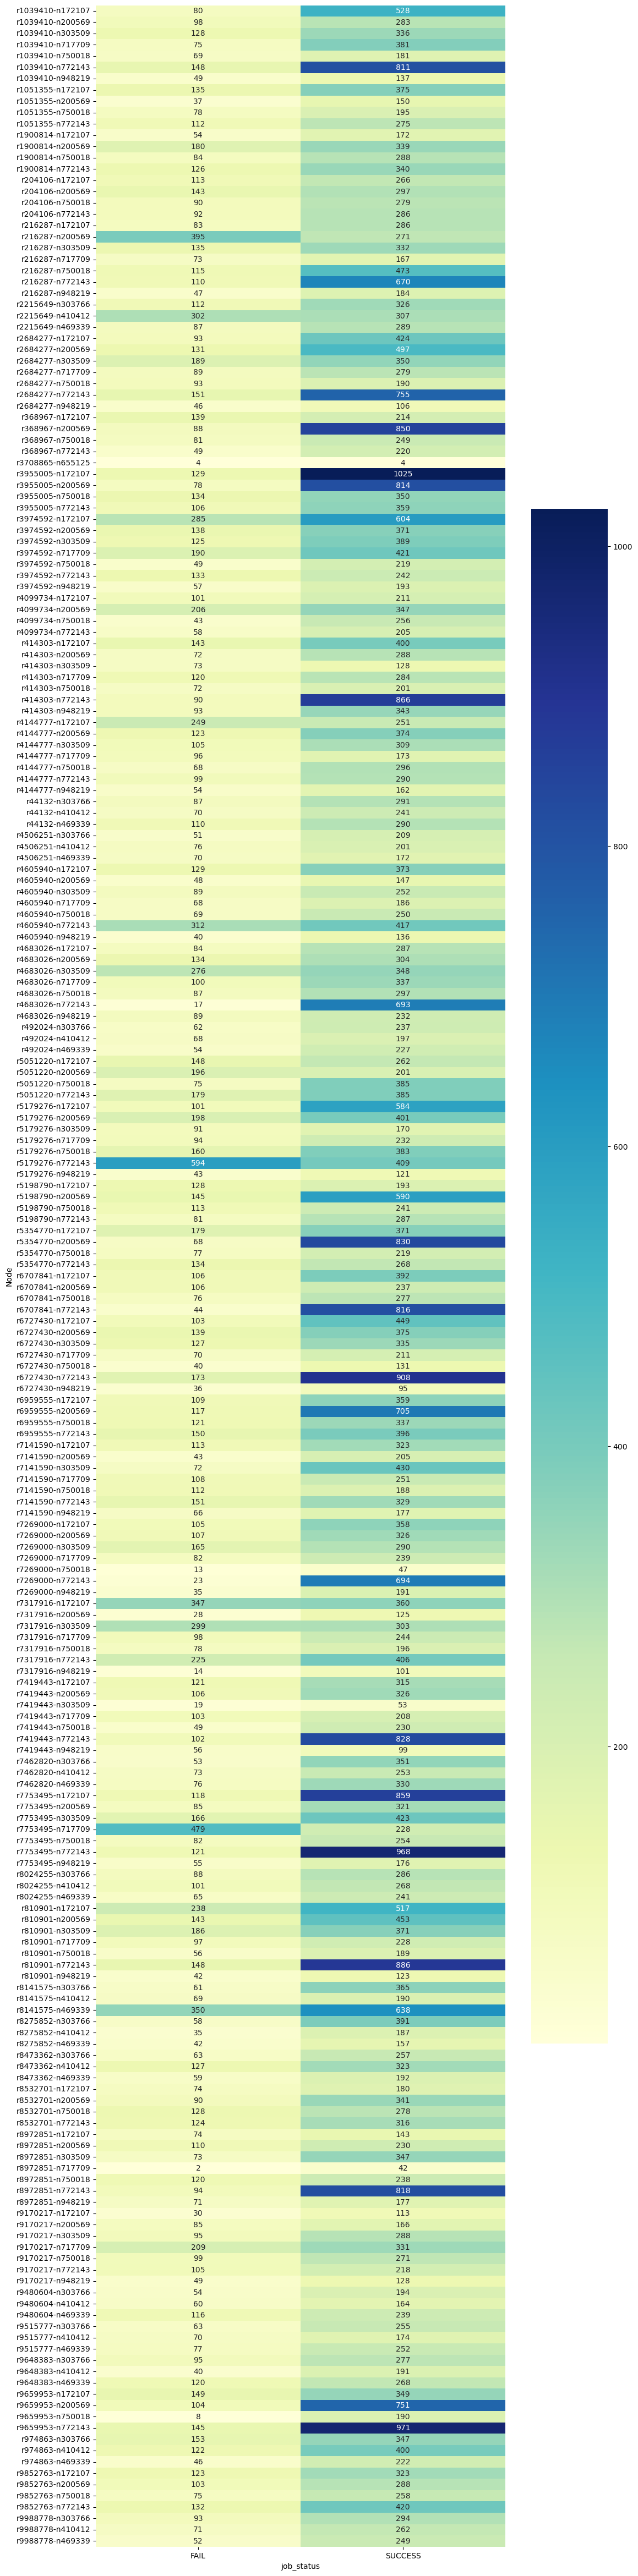

In [23]:
crosstab = pd.crosstab(df['Node'], df['job_status'])
plt.figure(figsize=(12, 60))
sns.heatmap(crosstab, annot=True, cmap="YlGnBu", fmt="d")
plt.plot()

[]

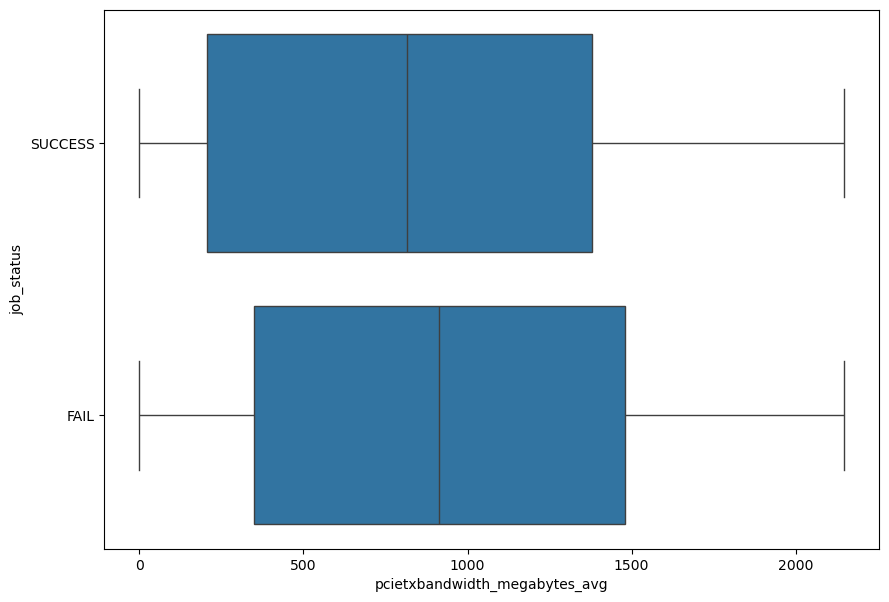

In [24]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='pcietxbandwidth_megabytes_avg', y='job_status')
plt.plot()

[]

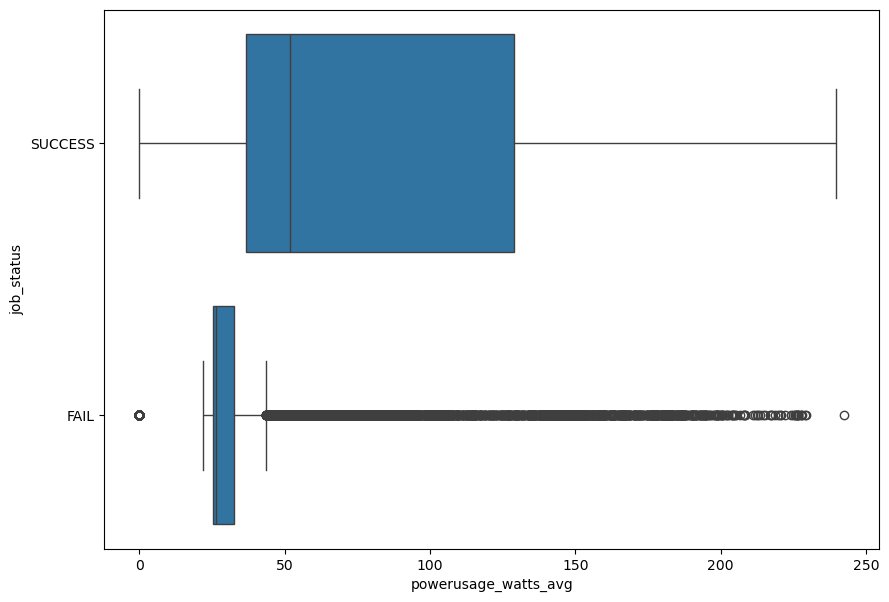

In [25]:
plt.figure(figsize=(10, 7))
sns.boxplot(data=df, x='powerusage_watts_avg', y='job_status')
plt.plot()

# **Data Cleaning**

## Drop duplicate rows

In [26]:
df = df.drop_duplicates()

## Drop `gres_used` since it only contains null values

In [27]:
df = df.drop(columns=['gres_used']) # Exclude column with null values

## Drop rows with null values in the dataset

In [28]:
df = df.dropna()

## Label Encode intersting columns

In [29]:
df['Node_encoded'] = label_encoder.fit_transform(df['Node'])
df['gres_alloc_encoded'] = label_encoder.fit_transform(df['gres_alloc'])
df['gres_req_encoded'] = label_encoder.fit_transform(df['gres_req'])

## Address class imbalance by undersampling to align the dataset with the `FAIL` class distribution

In [30]:
df_success = df[df['job_status'] == 'SUCCESS']
df_fail = df[df['job_status'] == 'FAIL']

df_success_undersampled = resample(df_success,
                                   replace=False,  # Don't resample with replacement
                                   n_samples=len(df_fail),  # Match the number of FAIL
                                   random_state=42)  # Reproducible results

df = pd.concat([df_success_undersampled, df_fail])

print(df['job_status'].value_counts())

job_status
SUCCESS    24182
FAIL       24182
Name: count, dtype: int64


/tmp/ipykernel_10201/4251939466.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')


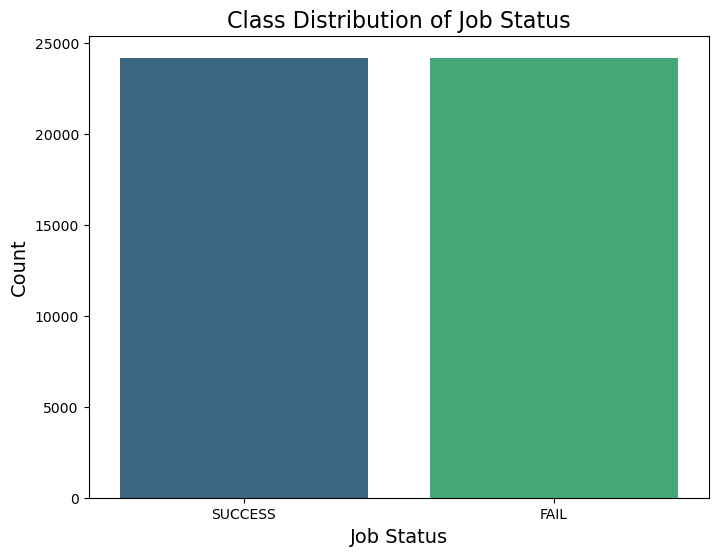

In [31]:
class_distribution = df['job_status'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_distribution.index, y=class_distribution.values, palette='viridis')
plt.title('Class Distribution of Job Status', fontsize=16)
plt.xlabel('Job Status', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=0)
plt.show()

# **Building classification models**

## Use `memoryutilization_pct_max`, `cpus_req`, `totalexecutiontime_sec`, and `maxgpumemoryused_bytes` as independent variables and `job_status` as dependent variable

In [32]:
X = df[['memoryutilization_pct_max','cpus_req', 'totalexecutiontime_sec','maxgpumemoryused_bytes']]
y = df['job_status']

## Perform dataset splitting

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Decision Tree Model

In [34]:
clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation
cv_accuracy = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_accuracy}")
print(f"Mean cross-validation accuracy: {cv_accuracy.mean():.2f}")

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test set accuracy: {accuracy:.2f}")
print(f"Test set F1 score: {f1:.2f}")
print(f"Test set precision: {precision:.2f}")
print(f"Test set recall: {recall:.2f}")

# Feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Cross-validation accuracy scores: [0.87330183 0.88393385 0.88304784 0.88954519 0.87621861 0.88301329
 0.89305761 0.87533235 0.88892171 0.8901034 ]
Mean cross-validation accuracy: 0.88
Test set accuracy: 0.89
Test set F1 score: 0.89
Test set precision: 0.89
Test set recall: 0.89
Feature Importance:
                     Feature  Importance
2     totalexecutiontime_sec    0.361561
0  memoryutilization_pct_max    0.351581
3     maxgpumemoryused_bytes    0.164857
1                   cpus_req    0.122001


## Random Forest Model

In [35]:
clf = RandomForestClassifier(random_state=42, criterion='entropy')

# Perform cross-validation
cv_accuracy = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')

print(f"Cross-validation accuracy scores: {cv_accuracy}")
print(f"Mean cross-validation accuracy: {cv_accuracy.mean():.2f}")

# Fit the model
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred, average='weighted')
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Test set accuracy: {accuracy:.2f}")
print(f"Test set F1 score: {f1:.2f}")
print(f"Test set precision: {precision:.2f}")
print(f"Test set recall: {recall:.2f}")

# Feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

Cross-validation accuracy scores: [0.89131719 0.89810986 0.90578854 0.90696988 0.89985229 0.89926145
 0.90694239 0.89423929 0.90605613 0.90960118]
Mean cross-validation accuracy: 0.90
Test set accuracy: 0.91
Test set F1 score: 0.91
Test set precision: 0.91
Test set recall: 0.91
Feature Importance:
                     Feature  Importance
2     totalexecutiontime_sec    0.434924
3     maxgpumemoryused_bytes    0.224635
0  memoryutilization_pct_max    0.211888
1                   cpus_req    0.128553


## LightGBM Model for production use

In [36]:
# Encode target variable
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Classifier hyperparameters
param_grid = {
    'objective': 'binary',
    'num_leaves': 100,
    'max_depth': 20,
    'n_estimators': 300,
    'random_state': 42,
    'verbose': -1
}

# Initialize LightGBM classifier
clf = lgb.LGBMClassifier(**param_grid)

# Perform cross-validation
cv_accuracy = cross_val_score(clf, X_train, y_train_encoded, cv=10, scoring='accuracy')
print(f"Cross-validation accuracy scores: {cv_accuracy}")
print(f"Mean cross-validation accuracy: {cv_accuracy.mean():.2f}")

# Fit the model
clf.fit(X_train, y_train_encoded)

# Make predictions
y_pred = clf.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test_encoded, y_pred)
f1 = f1_score(y_test_encoded, y_pred, average='weighted')
precision = precision_score(y_test_encoded, y_pred, average='weighted')
recall = recall_score(y_test_encoded, y_pred, average='weighted')

print(f"Test set accuracy: {accuracy:.2f}")
print(f"Test set F1 score: {f1:.2f}")
print(f"Test set precision: {precision:.2f}")
print(f"Test set recall: {recall:.2f}")

# Feature importance
feature_importances = clf.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

print("Feature Importance:")
print(feature_importance_df)

# Pickle both label_encoder and lightgbm model to use in flask
joblib.dump((clf, label_encoder), 'lgbm_model_and_encoder.pkl')

Cross-validation accuracy scores: [0.89013585 0.89131719 0.9019492  0.9037212  0.89542097 0.89542097
 0.90339734 0.89483013 0.9042836  0.90753323]
Mean cross-validation accuracy: 0.90
Test set accuracy: 0.90
Test set F1 score: 0.90
Test set precision: 0.90
Test set recall: 0.90
Feature Importance:
                     Feature  Importance
2     totalexecutiontime_sec       11118
3     maxgpumemoryused_bytes        8344
1                   cpus_req        5156
0  memoryutilization_pct_max        5082


['lgbm_model_and_encoder.pkl']